In [400]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [401]:
#torch data set
class dataSetAll(Dataset):
    def __init__(self, yearLow, yearHigh,numFeat,numOut):
        #import data from CDC
        self.df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
        self.df = self.df[(yearLow <= self.df["YEAR"]) & (self.df["YEAR"] < yearHigh)]["TOTAL"]
        #turn data into features and output
        #features: 5 previous + one from last year for predicted
        #output: prediction for next time

        #create test data
        self.numFeat = numFeat #------------------------
        self.numOut = numOut
        self.data = np.asarray(self.df,dtype=np.float32)
        self.data = torch.as_tensor(self.data)

    def __len__(self):
        return len(self.data)-self.numFeat-self.numOut
    
    def __getitem__(self,idx):
        # idx = 0
        return self.data[idx:idx+self.numFeat],self.data[idx+self.numFeat:idx+self.numFeat+self.numOut]

In [402]:
#create data loaders
numFeat = 10
numOut = 1
train_data = dataSetAll(1900,2013,numFeat,numOut)
test_data = dataSetAll(2013,2100,numFeat,numOut)
train_dataloader = DataLoader(train_data, batch_size=100,drop_last=False,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=100,drop_last=False,shuffle=True)
# print(next(iter(train_dataloader))[0])

In [403]:
# # create our RNN based network with an RNN followed by a linear layer
# inputSize = 1
# sequenceLength = numFeat
# numLayers = 1
# hiddenSize = 32
# batchSize = 100

# class LSTM(nn.Module):
#     def __init__(self,inputSize,hiddenSize,numLayers):
#         super(LSTM, self).__init__()
#         self.inputSize = inputSize
#         self.hiddenSize = hiddenSize
#         self.numLayers = numLayers
#         # print(batchSize,sequenceLength,inputSize)
#         self.LSTM = nn.LSTM(inputSize,hiddenSize,numLayers,batch_first=True)
#         # self.lstm1 = nn.LSTMCell(1,hiddenSize,bias=False)
#         # self.lstm2 = nn.LSTMCell(hiddenSize,hiddenSize,bias=False)
#         self.fc = nn.Linear(hiddenSize,1)
        
#     def forward(self,x):
#         # print(x.size())
#         out, _ = self.LSTM(x) #lstm with input, hidden, and internal state
#         out = self.fc(out[:,-1,:])
#         return out
#         # outputs = []
#         # nSamples = x.size(0)
#         # h_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
#         # c_1 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
#         # h_2 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
#         # c_2 = torch.zeros(nSamples, self.hiddenSize, dtype=torch.float32)
        
#         # for input in x.split(1,dim=1):
#         #     h_1, _ = self.lstm1(input, (h_1,c_1))
#         #     # h_2, _ = self.lstm2(h_1, (h_2,c_2))
#         #     out = self.fc(h_1)
#         #     outputs.append(out)

#         # for i in range(self.future):
#         #     h_1, _ = self.lstm1(input, (h_1,c_1))
#         #     # h_2, _ = self.lstm2(h_1, (h_2,c_2))
#         #     out = self.fc(h_1)
#         #     outputs.append(out)
        
#         # outputs = torch.cat(outputs, dim=1)
#         # return outputs

# model = LSTM(inputSize,hiddenSize,numLayers)

In [404]:
#train/test loop
def train_loop(dataloader, model, loss_fn, optimizer,t):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # print(X.size())
        X = X[:,:,None]
        pred = model(X)
        # print(pred.size())
        # print(y.size())
        loss = loss_fn(pred, y)
        # print("pred",pred)
        # print("Y",y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % size == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss({t}): {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [405]:
learning_rate = .01
batch_size = 100
epochs = 500
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# print(list(model.parameters()))

# print(list(model.parameters()))
for t in range(epochs):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,t)
    # test_loop(test_dataloader, model, loss_fn)

print("Done!")
# print(list(model.parameters()))

loss(0): 43923292.000000  [    0/  782]
loss(1): 54222640.000000  [    0/  782]
loss(2): 34840144.000000  [    0/  782]
loss(3): 58759036.000000  [    0/  782]
loss(4): 35890464.000000  [    0/  782]
loss(5): 37953264.000000  [    0/  782]
loss(6): 53351876.000000  [    0/  782]
loss(7): 35724616.000000  [    0/  782]
loss(8): 37718440.000000  [    0/  782]
loss(9): 40170900.000000  [    0/  782]
loss(10): 25049500.000000  [    0/  782]
loss(11): 46014812.000000  [    0/  782]
loss(12): 45944340.000000  [    0/  782]
loss(13): 53326332.000000  [    0/  782]
loss(14): 26013428.000000  [    0/  782]
loss(15): 49552384.000000  [    0/  782]
loss(16): 27534010.000000  [    0/  782]
loss(17): 34214720.000000  [    0/  782]
loss(18): 20405960.000000  [    0/  782]
loss(19): 34893088.000000  [    0/  782]
loss(20): 35590272.000000  [    0/  782]
loss(21): 40567056.000000  [    0/  782]
loss(22): 20840392.000000  [    0/  782]
loss(23): 20904788.000000  [    0/  782]
loss(24): 25229384.000000 

KeyboardInterrupt: 

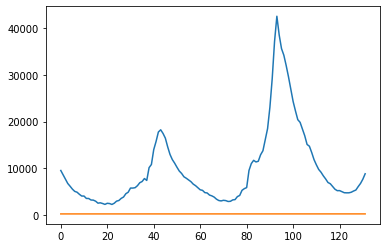

In [ ]:
def test_loop(dataloader, model):
    yearLow = 2013
    yearHigh = 2020
    df = pd.read_csv("data\FluViewPhase2Data\WHO_NREVSS_Combined_prior_to_2015_16.csv")
    df = df[(yearLow <= df["YEAR"]) & (df["YEAR"] < yearHigh)]["TOTAL"]
    data = np.array(df)
    numFeat = 10 #------------------------
    numOut = 1

    size = len(data)-numFeat-numOut

    with torch.no_grad():
        for idx in range(4,len(test_data)):
            feat = test_data[idx][0]
            y = test_data[idx][1]
            X = feat
            pred = model(X).squeeze().numpy()
            plt.plot(np.append(feat,pred))
            plt.plot(np.append(feat,y))
            
            plt.show()
            
def graph(model):
    with torch.no_grad():
        predY = []
        actY = []
        for idx in range(len(test_data)):
            feat = test_data[idx][0]
            y = test_data[idx][1]
            X = feat[None,:,None]
            # print(X.size())
            pred = model(X)
            predY.append(pred.numpy()[0][-1])
            actY.append(y.numpy()[-1])
            # plt.plot(np.append(feat,pred))
            # plt.plot(np.append(feat,y))
            
            
        
        plt.plot(actY) 
        plt.plot(predY)
        plt.show()

graph(model)
# test_loop(test_dataloader,model)
